In [53]:
%%writefile ../../src/features/mask_radius.py
import xarray as xr
import numpy as np
from features.log_progress import log_progress

find = lambda searchList, elem: [[i for i, x in enumerate(searchList) if x == e] for e in elem]

def rosby_mask(mask_da,mask_rho,r=10):
    
    neibours_add = []
    for n_xi in np.arange(0,r+1,2):
        for n_eta in np.arange(0,r+1,2):
            if (n_xi**2 + n_eta**2) <= r**2:
                neibours_add.append([n_xi,n_eta])
                if n_xi > 0:
                    neibours_add.append([-n_xi,n_eta])
                if n_eta > 0:
                    neibours_add.append([n_xi,-n_eta])
                if n_xi > 0 and n_eta > 0:
                    neibours_add.append([-n_xi,-n_eta])
                  
    mask_rho_stacked = mask_rho.stack(xieta=('xi_rho','eta_rho')).values
    xieta = mask_rho.stack(xieta=('xi_rho','eta_rho')).xieta.values
    
    xi_len = mask_rho.xi_rho.size
    eta_len = mask_rho.eta_rho.size
    for xi in log_progress(np.arange(xi_len),name='xi'):
        for eta in np.arange(eta_len):
            if mask_da[eta,xi] == 1:          
                neibours = np.add(neibours_add,(xi,eta))
                new=[]
                for ind,neib in enumerate(neibours):
                    if (0 <= neib[0] <= xi_len-1) and (0 <= neib[1] <= eta_len-1):
                        new.append(tuple(neib))
                neibours = new
                    
                stack_ind = np.squeeze(find(xieta,neibours))
                if (mask_rho_stacked[stack_ind]==0).any():
                    mask_da[eta,xi] = 0
                
    return mask_da

Overwriting ../../src/features/mask_radius.py


In [40]:
from scipy import ndimage
a = grid.mask_rho.values
a[grid.zice.values < 0.0] = 0

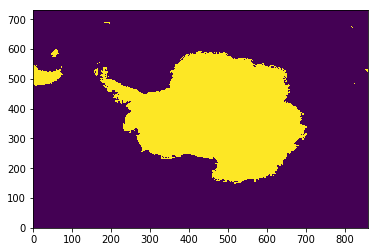

In [41]:
plt.close()
plt.pcolormesh(np.logical_not(a))
plt.show()

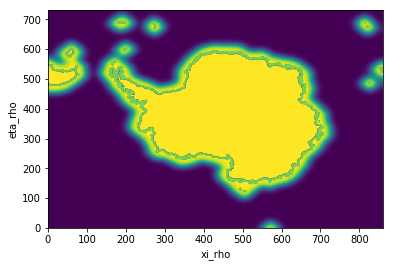

In [44]:
b = ndimage.binary_dilation(np.logical_not(a),iterations=25).astype(a.dtype)
from scipy.ndimage.filters import gaussian_filter, uniform_filter
c = gaussian_filter(b,10)
plt.close()
plt.pcolormesh(c,alpha=0.5)
grid.mask_rho.plot.contour()
plt.show()